<div style="color:#8b1538; font-size:35px;">Benchmark of Dadi</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms
import sei.sei as sei

<br>

> Load data

In [2]:
# data_all = f.export_inference_files(model='decline', fold=False, param='all')

data_all = pd.read_json('./Data/Dadi/decline/all/dadi_decline-all_bu.zip')  # back-up data

In [3]:
save = True  # if set to true each heatmap is save to a png format

<br>

# Plot some inferred SFS and the theoretical one

In [21]:
def get_data(df):
    parameters = [0., 1., -1]
    data = {0: [], 1: [], -1: []}
    
    for _, row in df.iterrows():
        param = {
            k: round(np.log10(v), 2) for k, v in row['Parameters'].items() if k != 'Theta'
        }
        if param['Tau'] in parameters and param['Kappa'] in parameters:
            data[param['Tau']].append({'Parameters': param, 'SFS': row['SFS observed'][0]})

    return data


def plot_sfs(data, ax, title, xaxis=True):
    for value in data:
        # Normalization of the SFS
        normalized_sfs = plot.normalization(value['SFS'])
            
        # Color
        if value['Parameters']['Kappa'] > 0:
            label = 'Scénario de décroissance - κ = {}'.format(value['Parameters']['Kappa'])
            color = 'red'
        elif value['Parameters']['Kappa'] < 0:
            label = 'Scénario de croissance - κ = {}'.format(value['Parameters']['Kappa'])
            color = 'green'
        else:
            label = 'Scénario constant - κ = {}'.format(value['Parameters']['Kappa'])
            color= 'blue'
            
        # Plot
        ax.plot(normalized_sfs, label=label, color=color)
        
    # Plot theoretical SFS
    theoretical_sfs = plot.normalization(plot.compute_theoretical_sfs(len(normalized_sfs)))
    ax.plot(theoretical_sfs, color='orange', marker="o", label="SFS théorique - Fu, 1995")
    
    # Compute X axis ticks & values
    x_ax, x_values = [], []
    for i in range(10):
        x_ax.append(i+i)
        x_values.append("{}/{}".format(i*2+1, len(theoretical_sfs)+1))
        
    # X axis ticks & labels
    ax.set_xticks(x_ax)
    ax.set_xticklabels(x_values)

    # Label axis
    if xaxis:
        ax.set_xlabel("Fréquence allélique", fontsize="x-large")
    ax.set_ylabel("SNPs - pourcentage", fontsize="x-large")

    # Title
    ax.set_title(title, fontsize='xx-large')


def plot_all_sfs(df, suptitle, save):
    """
    Plot the theoretical SFS vs the observed ones.
    """
    # Set up plot
    _,  ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14), sharey=True)
    ax4.set_visible(False)
    plt.subplots_adjust(hspace=0.16)
    
    # SFS to select fo each ax
    data = get_data(df)

    
    plot_sfs(data[0], ax1, title="Scénario de changement de taille de population pour τ = 0", xaxis=False)
    plot_sfs(data[1], ax2, title="Scénario de changement de taille de population ancien pour τ = 1")
    plot_sfs(data[-1], ax3, title="Scénario de changement de taille de population récent pour τ = -1")

    # Sup title
    plt.suptitle(suptitle, fontsize='xx-large', fontweight='bold', y=0.936)

    # Common legend
    #fig.legend()
    lines, labels = ax1.get_legend_handles_labels()
    #plt.figlegend(lines, labels, loc = 'lower center', ncol=5, labelspacing=0. )
    plt.figlegend(lines, labels, fontsize='x-large', loc='center right', ncol=1,
                  bbox_to_anchor=(0.18, 0., 0.5, 0.4))
    
    if save:
        plt.savefig('./Figures/Dadi/sfs_observe.png', format='png', dpi=150, bbox_inches='tight')
    plt.show()

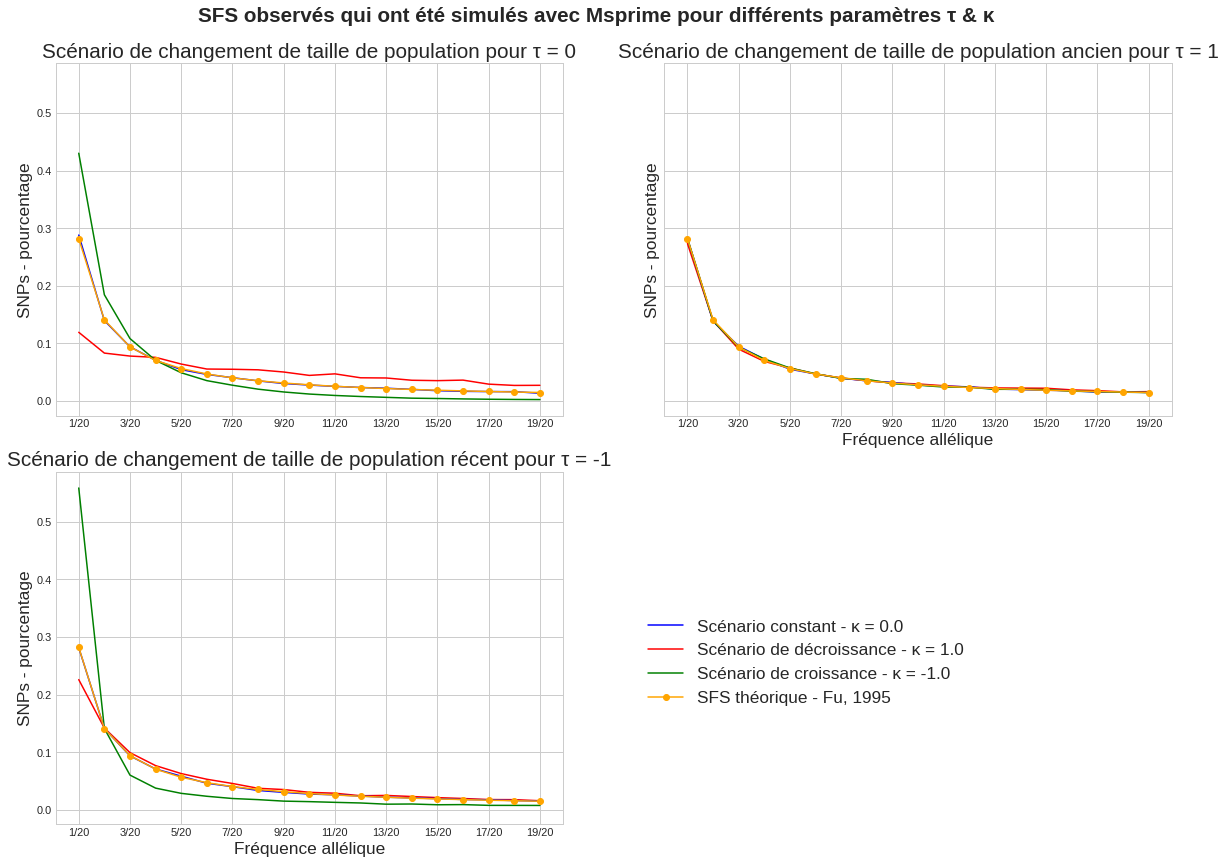

In [22]:
title = "SFS observés qui ont été simulés avec Msprime pour différents paramètres τ & κ"

with plt.style.context('seaborn-whitegrid'):  # use seaborn style for plot
    plot_all_sfs(data_all, title, save)

<br>

# Analysis

<div style="color: #8b1538; font-size: 28px">1. Weighted square distance</div><br>

The weighted square distance $\large{d^2}$ is:

1. Between the observed SFS $\large{\eta^{obs}}$ and the predicted SFS by model M1 $\large{\eta^{model}}$ [1]

\begin{equation}
\Large{ d^2(\eta^{model}, \eta^{obs}) = \sum_{i=1}^{n}{\frac{(\eta^{model}_i - \eta^{obs}_i)^2}{\eta^{model}_i }} }
\end{equation}

2. Between the inferred SFS of two models ($\large{\eta^{m2}}$ & $\large{\eta^{m1}}$)

\begin{equation}
\Large{ d^2(\eta^{m0}, \eta^{m1}) = \sum_{i=1}^{n}{\frac{(\eta^{m0}_i - \eta^{m1}_i)^2}{ (\eta^{m0}_i + \eta^{m1}_i) / 2 }} }
\end{equation}

Start the sum from 2 to ignore singletion (i=2).

<br>

<div style="color: #8b1538; font-size: 15px;">[1] Each SFS must be normalized for comparison</div>

> Compute weighted square distance between theoritical SFS of any constant population & observed SFS (msprime)

Permet  de déterminer pour quel paramètre (Tau, Kappa) les SFS observés sont différenciés du SFS théorique de n'importe quelle population constante, i.e. déterminer quand les SFS permettent de repérer un changement de taille de population.

In [10]:
def compute_theoritical_sfs(length):
    """
    compute the theoritical sfs of any constant population.
    """
    theoritical_sfs = [0] * (length)
    for i in range(length):
        theoritical_sfs[i] = 1 / (i+1)
    return theoritical_sfs


def normalization(sfs):
    """
    Normalization to (0;1)
    """
    return [ele / sum(sfs) for ele in sfs]


def compute_weighted_square_distance(data):
    theoritical_sfs = normalization(compute_theoritical_sfs(19))
    d2 = {}
    
    for i, row in data.iterrows():
        d2[i] = []
        for sfs in row['SFS observed']:
            #for eta_obs, eta_theo in zip(normalization(sfs), theoritical_sfs):
                #d2[i].append(np.power(eta_obs - eta_theo, 2) / eta_theo)
            d2[i].append(
                sum([np.power(eta_obs - eta_theo, 2) / eta_theo for eta_obs, eta_theo in zip(normalization(sfs), theoritical_sfs)])
            )

        d2[i] = np.mean(d2[i])

    return d2

<br>

<div style="color: #8b1538; font-size: 32px">2. Log-likelihood ratio test</div><br>

Likelihood ratio test lrt assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

1. Likelihood ratio test

\begin{equation}
\large{ lrt = -2*\frac{L0}{L1} }
\end{equation}

with L0 the likelihood of m0 and L1 the likelihood of m1 <br>

2. Log-likelihood ratio test

\begin{equation}
\large{ log(lrt) = 2 * (log_{10}L1 - log_{10}L0) }
\end{equation}

with $log_{10}L0$ the log-likelihood of m0 and $log_{10}L1$ the log-likelihood of m1

<br>

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

<br>

<div style="color: #8b1538; font-size: 28px;">Vérification des paramètres estimés par Dadi</div>

Check infered parameters by Dadi.

<br>

# Sudden decline & growth model for each pair (Tau, Kappa) 

> Weighted square distance - observed SFS and theoritical SFS of any constant population

Indique pour quel couple (Tau, Kappa), les SFS observés sont différenciés des SFS théoriques de n'importe quelle population constante. 

In [13]:
data_all['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(data_all))

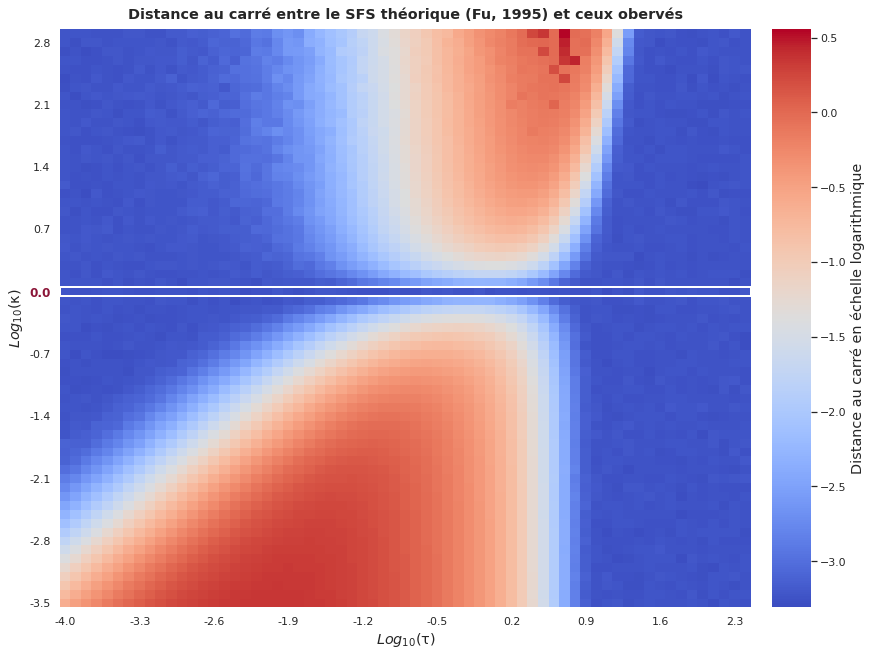

In [15]:
if save:
    title = "Distance au carré entre le SFS théorique (Fu, 1995) et ceux obervés"
else:
    title = "Weighted square distance between the theoretical SFS (Fu, 1995) & the observed ones"

plot.plot_weighted_square_distance_heatmap(
    data=data_all, d2='d2 observed theoritical', models=['observed', 'theoretical'], title=title, save=save
)

> Weighted square distance - observed SFS and inferred models (M1)

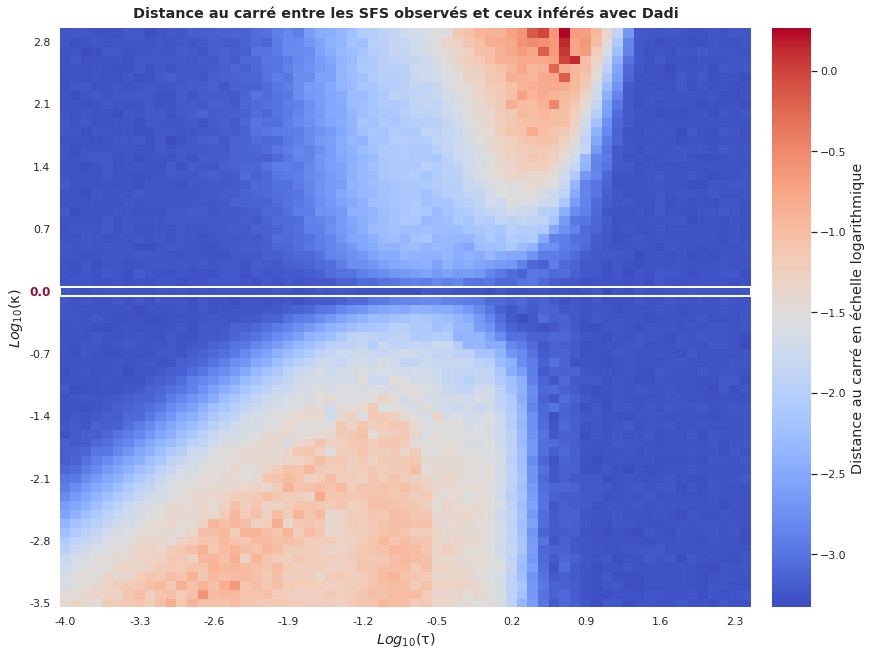

In [16]:
if save:
    title = "Distance au carré entre les SFS observés et ceux inférés avec Dadi"
else:
    title = "Weighted square distance between the observed SFS & the inferred ones"

plot.plot_weighted_square_distance_heatmap(
    data=data_all, d2='d2 observed inferred', models=['observed', 'inferred'], title=title, save=save
)

> Weighted square distance - M0 & M1

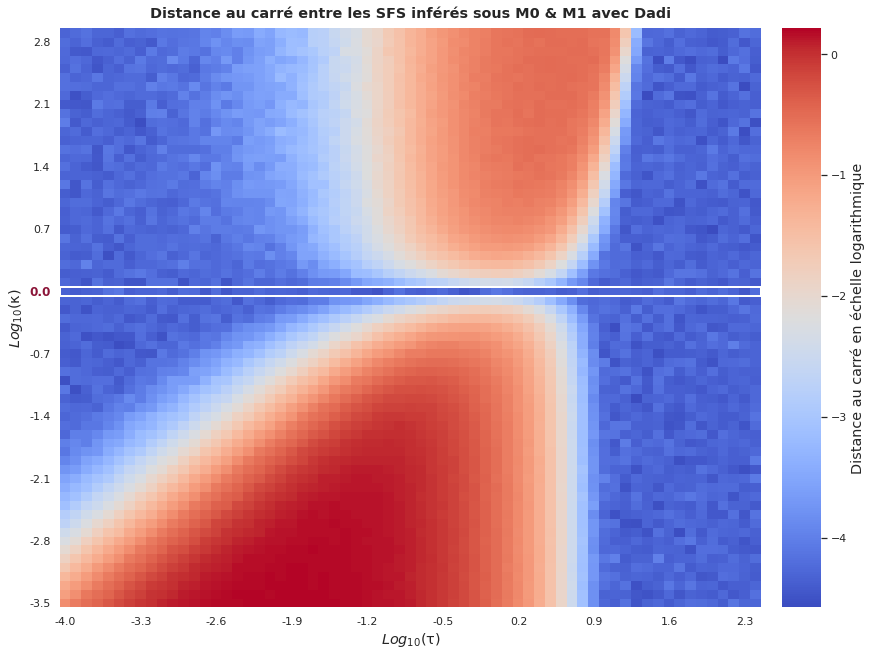

In [17]:
if save:
    title = "Distance au carré entre les SFS inférés sous M0 & M1 avec Dadi"
else:
    title = "Weighted square distance between the inferred SFS under M0 & M1"

plot.plot_weighted_square_distance_heatmap(
    data=data_all, d2='d2 models', models=['m0', 'm1'], title=title, save=save
)

<br>

> Log-likelihood ratio test

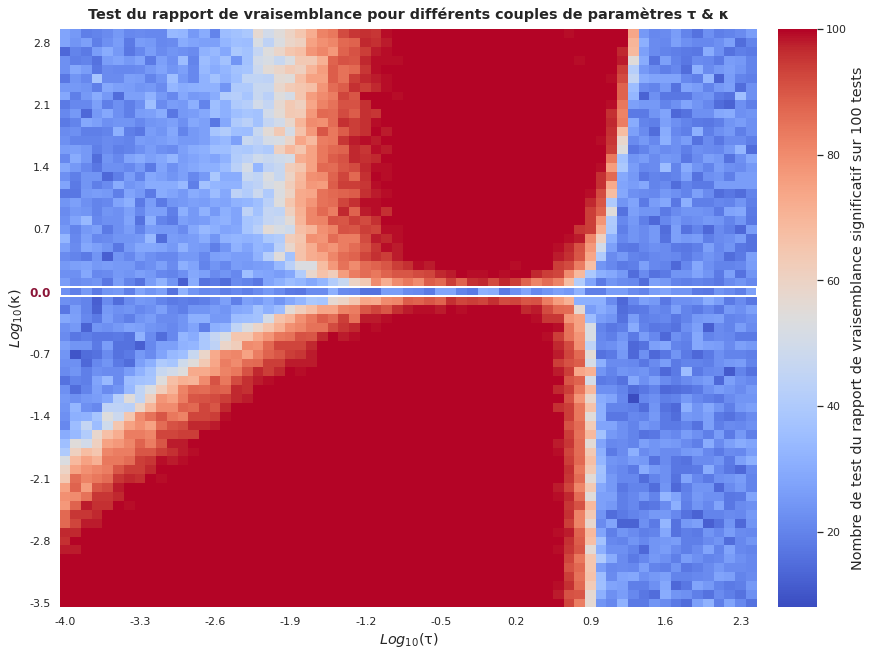

In [18]:
if save:
    title = "Test du rapport de vraisemblance pour différents couples de paramètres τ & κ"
else:
    title = "Log likelihood ratio test for various τ & κ - p.value = 0.05"
    
plot.plot_likelihood_heatmap(data_all, title=title, save=True)

> SFS shape

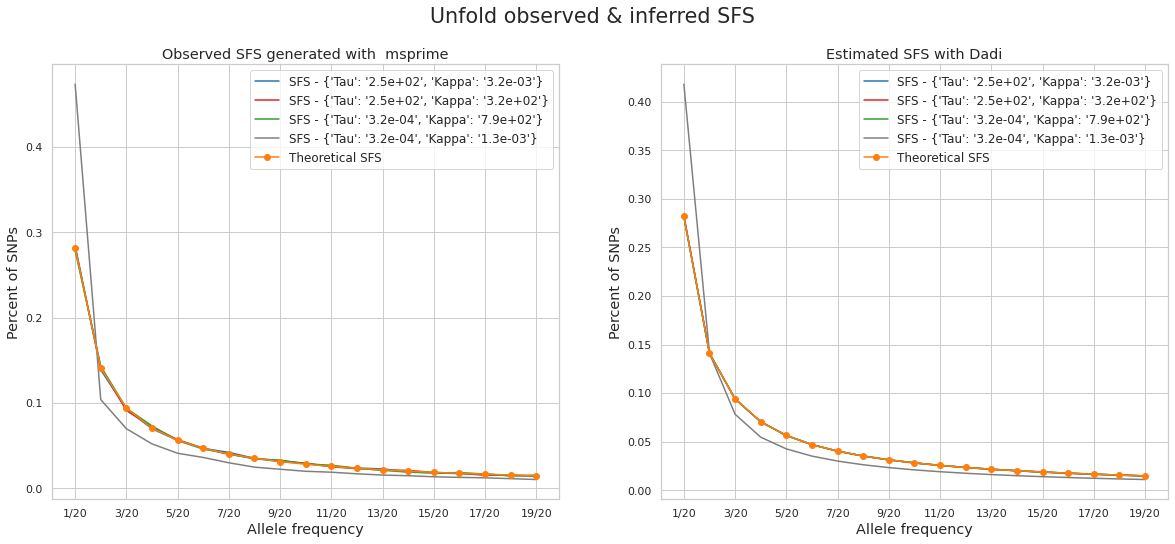

<Figure size 432x288 with 0 Axes>

In [63]:
plot.plot_sfs_inference(
    data=data_all, 
    parameters=[{'Tau': -3.5, 'Kappa': -2.9}, {'Tau': -3.5, 'Kappa': 2.9}, {'Tau': 2.4, 'Kappa': -2.5}, {'Tau': 2.4, 'Kappa': 2.5}], 
    colors=['tab:blue', 'tab:red', 'tab:green', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS"
)

<br>

> Vérification paramètre Dadi

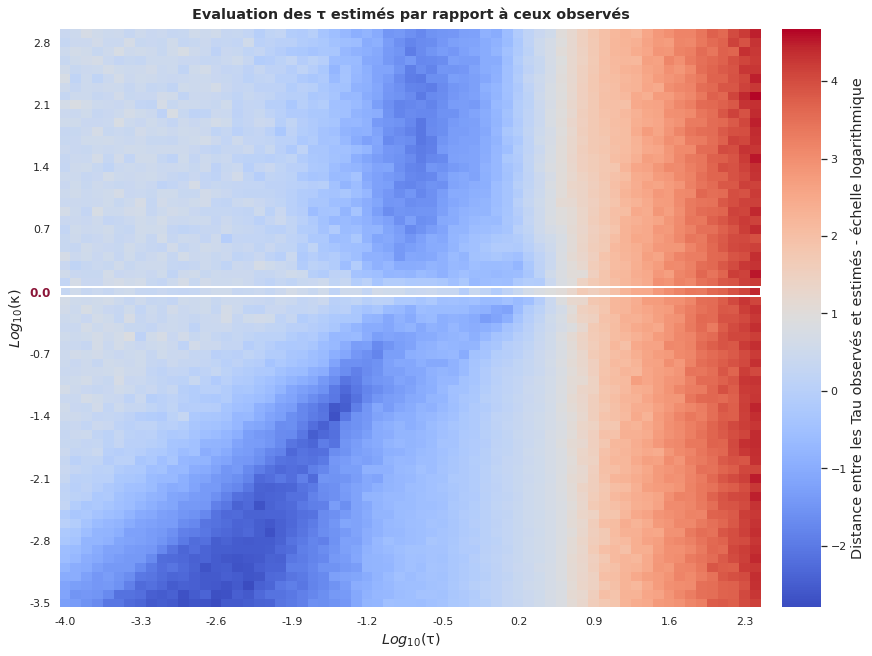

In [4]:
plot.plot_parameters_evaluation_heatmap(data_all, key="Tau", save=save)

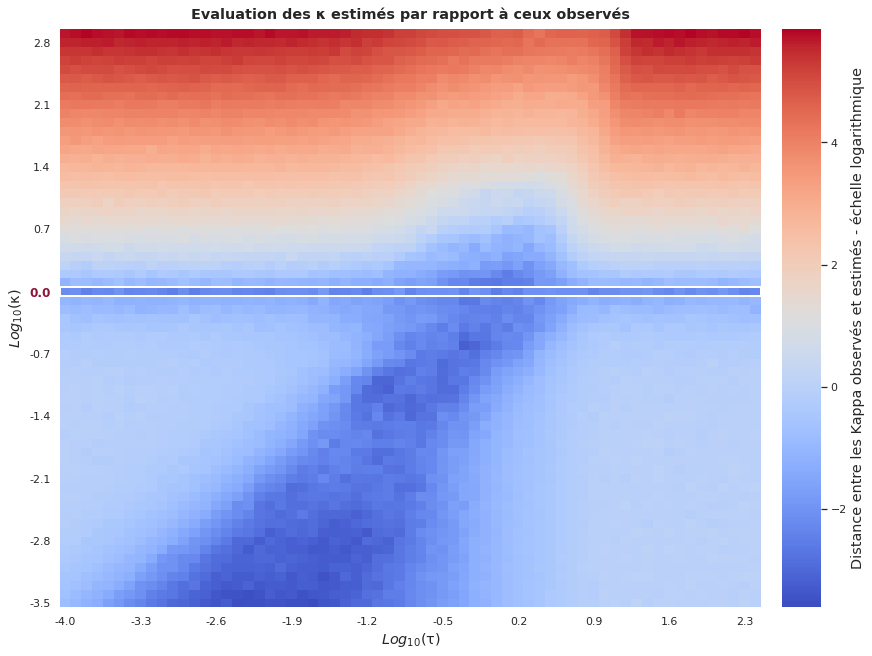

In [5]:
plot.plot_parameters_evaluation_heatmap(data_all, key="Kappa", save=save)

In [109]:
#plot_parameters_evaluation_heatmap(data_all, key="Theta")

<br>

# Fixed kappa - sudden decline & growth model 

## Kappa -3.5, 0. & 2.5 in log sacle, i.e. 3.2e-4, 1.0 & 3.2e2

> Load data

In [6]:
data_kappa, labels_kappa = \
    f.export_specific_dadi_inference(model='decline', fold=False, fixed_param='kappa', values=[-2.5, 0., 2.5])

> Weighted square distance

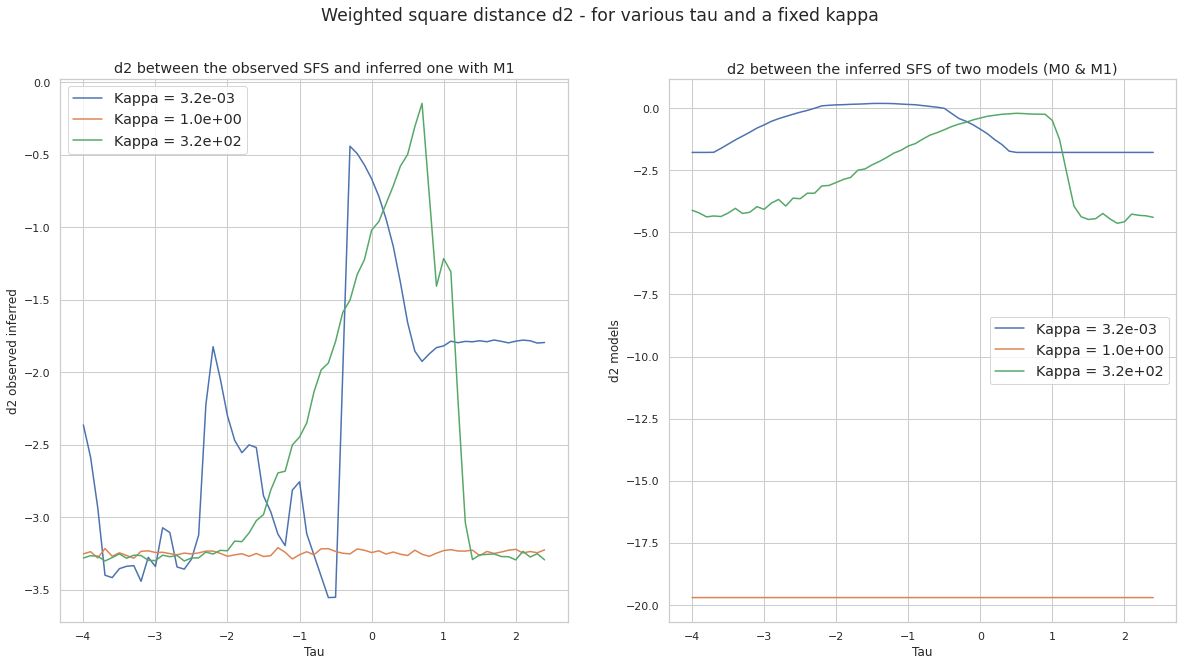

In [16]:
plot.plot_weighted_square_distance(
    data=data_kappa, fixed="Tau", labels=labels_kappa,
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa"
)

> Weighted square distance - observed SFS and theoritical SFS of any constant population

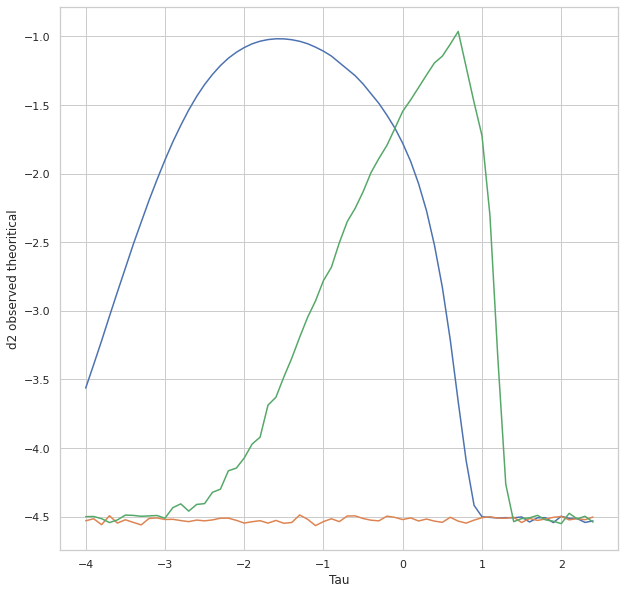

In [17]:
plt.figure(figsize=(10,10))
sns.set_theme(style='whitegrid')

for dataframe in data_kappa:
    # Data
    df = pd.DataFrame()
    df['Tau'] = dataframe['Parameters'].apply(lambda param: np.log10(param['Tau']))
    df['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(dataframe)).apply(np.log10)
    
    # Plot
    _ = sns.lineplot(x="Tau", y="d2 observed theoritical", data=df)

> SFS shape

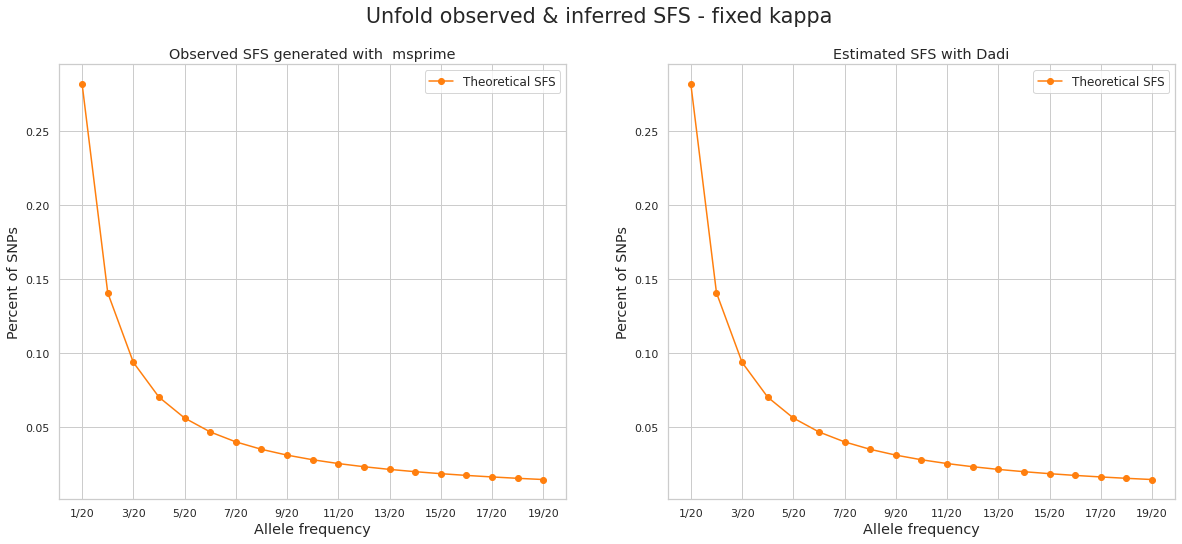

<Figure size 432x288 with 0 Axes>

In [18]:
plot.plot_sfs_inference(
    data=data_kappa[0], 
    parameters=[{'Tau': -3.5, 'Kappa': -3.5}, {'Tau': -3, 'Kappa': -3.5}, {'Tau': -2.5, 'Kappa': -3.5}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed kappa"
)

> Log-likelihood ratio test

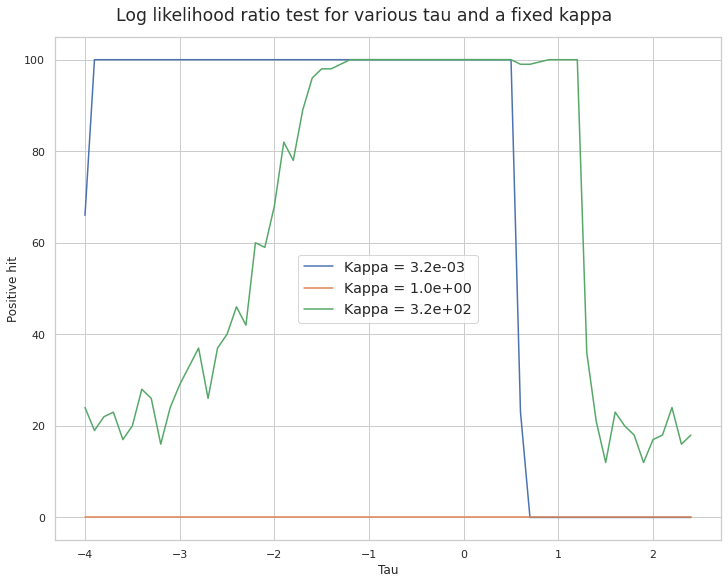

In [19]:
plot.plot_likelihood(
    data=data_kappa, fixed="Tau", labels=labels_kappa,
    suptitle="Log likelihood ratio test for various tau and a fixed kappa"
)

> Evaluation paramètres estimés

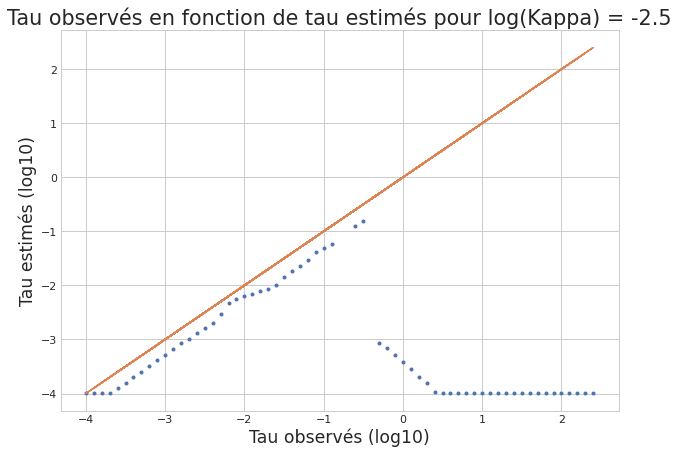

In [20]:
plot.plot_parameters_evaluation(data=data_kappa[0], key="Tau", fixed=('Kappa', -2.5))

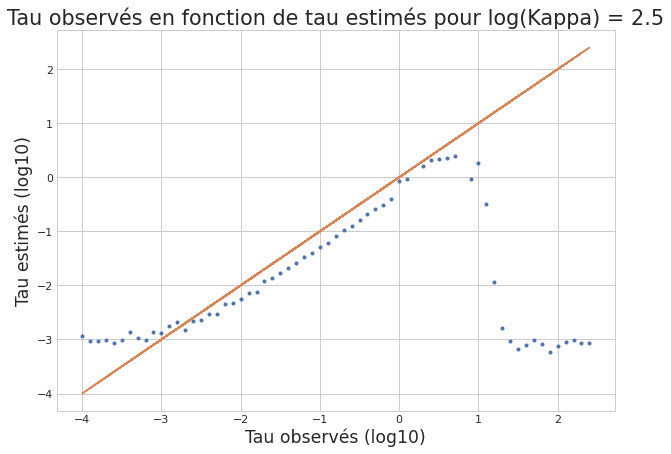

In [21]:
plot.plot_parameters_evaluation(data=data_kappa[2], key="Tau", fixed=('Kappa', 2.5))

<br>

## Kappa 0.3 & 1 in log scale, i.e. 2 & 10

> Load data

In [2]:
data_kappa2, labels_kappa2 = \
    f.export_specific_dadi_inference(model='decline', fold=False, fixed_param='kappa', values=[0.3, 1.])

> Weighted square distance

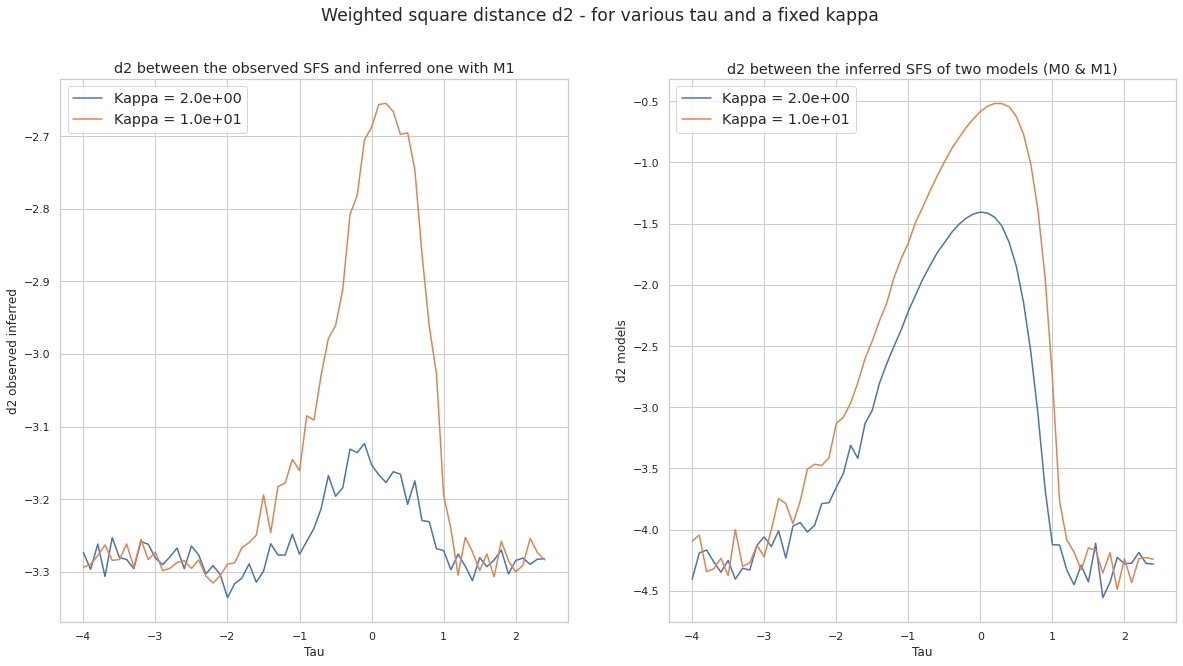

In [24]:
plot.plot_weighted_square_distance(
    data=data_kappa2, fixed="Tau", labels=labels_kappa2,
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa"
)

> Log-likelihood ratio test

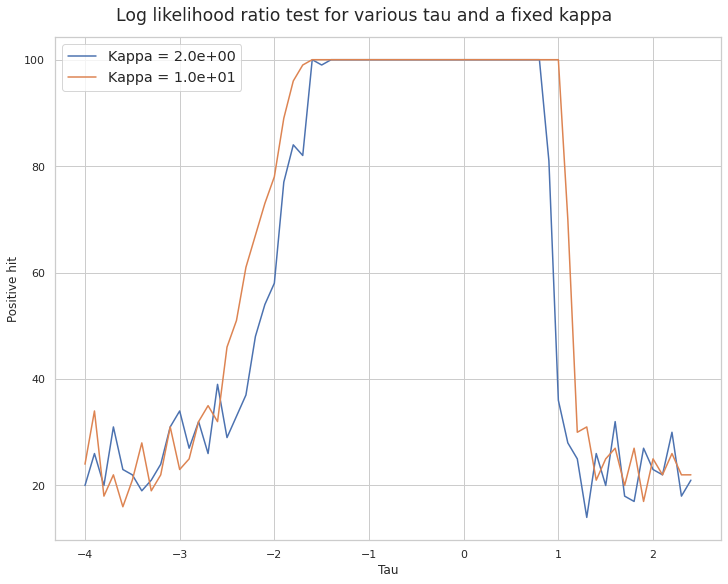

In [25]:
plot.plot_likelihood(
    data=data_kappa2, fixed="Tau", labels=labels_kappa2,
    suptitle="Log likelihood ratio test for various tau and a fixed kappa"
)

> SFS shape

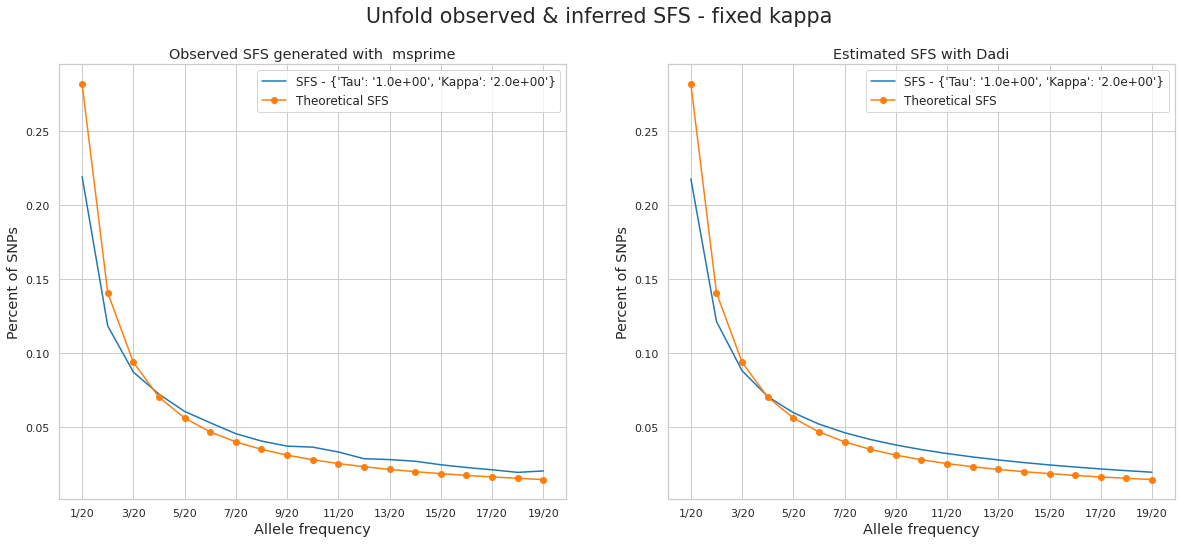

<Figure size 432x288 with 0 Axes>

In [26]:
plot.plot_sfs_inference(
    data=data_kappa2[0], 
    parameters=[{'Tau': 0., 'Kappa': 0.3}, {'Tau': 0., 'Kappa': 1}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed kappa"
)

> Evaluation paramètres estimés

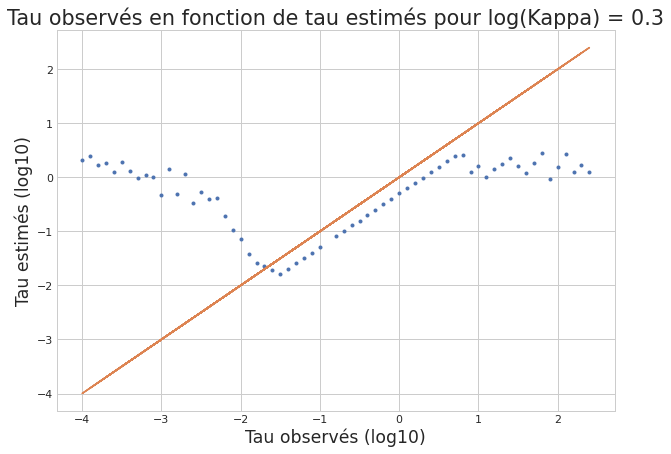

In [15]:
plot.plot_parameters_evaluation(data=data_kappa2[0], key="Tau", fixed=('Kappa', 0.3))

<br>

## Fixed tau - sudden decline & growth model 

### Tau -2.4, 0. & 2.4, i.e. 4e-3, 1. & 251

> Load data

In [8]:
data_tau, labels_tau = \
    f.export_specific_dadi_inference(model='decline', fold=False, fixed_param='tau', values=[-2.4, 0., 2.4])

> Weighted square distance

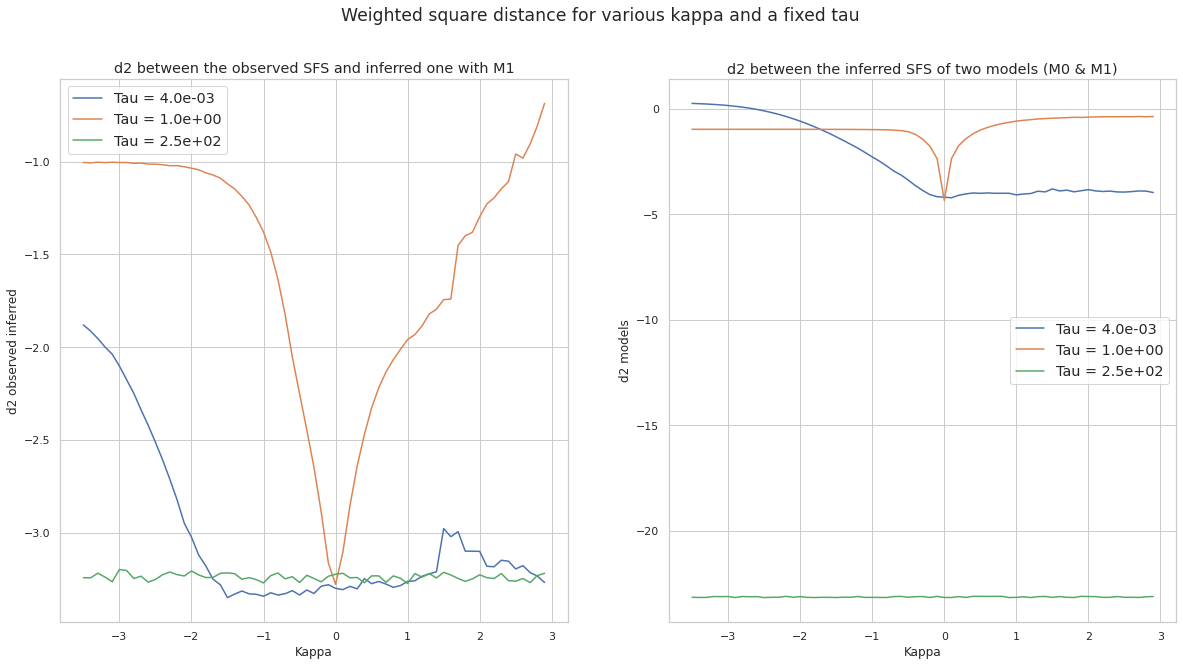

In [9]:
plot.plot_weighted_square_distance(
    data=data_tau, fixed="Kappa", labels=labels_tau,
    suptitle="Weighted square distance for various kappa and a fixed tau")

In [10]:
plt.figure(figsize=(10,7))
sns.set_theme(style='whitegrid')

for dataframe in data_tau:
    # Data
    df = pd.DataFrame()
    df['Kappa'] = dataframe['Parameters'].apply(lambda param: np.log10(param['Kappa']))
    df['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(dataframe)).apply(np.log10)
    
    # Plot
    _ = sns.lineplot(x="Kappa", y="d2 observed theoritical", data=df)

NameError: name 'compute_weighted_square_distance' is not defined

<Figure size 720x504 with 0 Axes>

> Log-likelihood ratio test

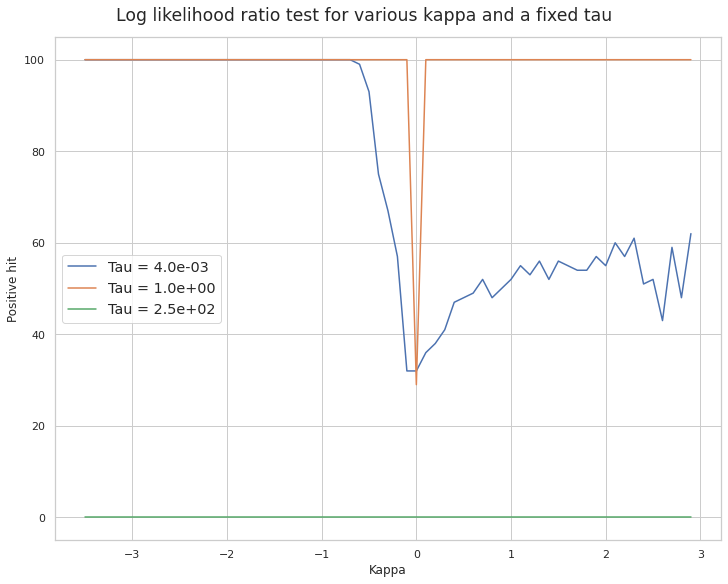

In [8]:
plot.plot_likelihood(
    data=data_tau, fixed="Kappa", labels=labels_tau,
    suptitle="Log likelihood ratio test for various kappa and a fixed tau")

> SFS shape

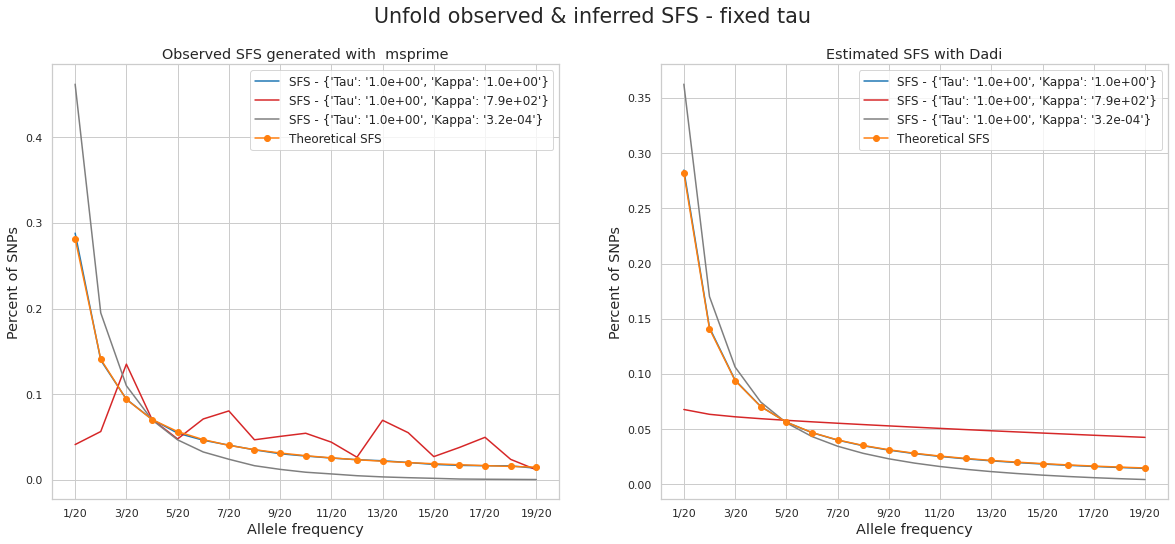

<Figure size 432x288 with 0 Axes>

In [32]:
plot.plot_sfs_inference(
    data=data_tau[1], 
    parameters=[{'Tau': 0., 'Kappa': -3.5}, {'Tau': 0., 'Kappa': 0}, {'Tau': 0., 'Kappa': 2.9}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed tau"
)

> Evaluation paramètres estimés

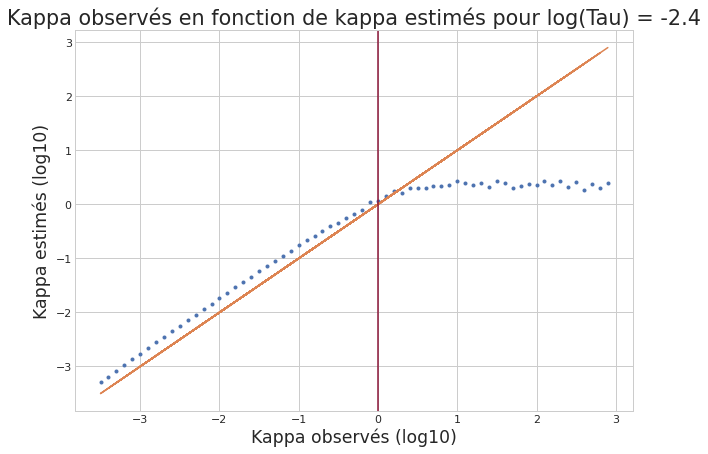

In [11]:
plot.plot_parameters_evaluation(data=data_tau[0], key="Kappa", fixed=('Tau', -2.4))